# Calibration with initial model memory states as parameters


## About this document

This document was generated from an R markdown file on `r as.character(Sys.time())`. It is a vignette to demonstrate features in SWIFT to calibrate a model with initial model states as a parameter.

## Essentials of setting up a calibration of initial states

This vignette will illustrate how to define two _meta-parameters_, _S0_ and _R0_, controlling the initial level of stores in the GR4J model, as fraction of the store capacities.

We'll load a simple catchment with one subarea only; the feature applies equally to catchment with multiple sub-areas

In [1]:
import pandas as pd
import numpy as np

In [2]:
from cinterop.timeseries import xr_ts_start, xr_ts_end
from swift2.classes import CompositeParameteriser

import swift2.doc_helper as std
import swift2.parameteriser as sp
import swift2.system as ssy
from swift2.utils import mk_full_data_id

In [3]:
%matplotlib inline

In [4]:
model_id = 'GR4J'
simul_start=pd.Timestamp('1990-11-01')
simul_end=pd.Timestamp('1992-12-31')
ms = std.create_subarea_simulation(data_id='MMH', simul_start=simul_start, simul_end=simul_end, 
	model_id=model_id, tstep='daily', varname_rain='P', varname_pet='E')

We define a few model state identifiers, and set them to be recorded to time series.

In [5]:
gr4jModelVars = ssy.runoff_model_var_ids(model_id)
print(gr4jModelVars)

['P', 'E', 'runoff', 'S', 'R', 'Ps', 'Es', 'Pr', 'ech1', 'ech2', 'Perc', 'x1', 'x2', 'x3', 'x4', 'UHExponent', 'PercFactor']


In [6]:
element_id = 'subarea.Subarea'
def mk_varid(short_id):
    return mk_full_data_id(element_id, short_id)

runoff_id = mk_varid('runoff')
s_store_id = mk_varid('S')
r_store_id = mk_varid('R')
ms.record_state([runoff_id, s_store_id, r_store_id])

We'll set up a short runtime span, so that we illustrate the state initialisation feature.

In [7]:
obs_runoff = std.sample_series('MMH', 'flow') #actually, this is a time series of runoff depth, not streamflow rate
obs_runoff[obs_runoff < -1] = np.nan
s = simul_start
w = s
# e = s + pd.DateOffset(days=90)
e = simul_end
ms.set_simulation_span(s, e)

Let's apply some default model parameters to the model:

In [8]:
pspec_gr4j = std.get_free_params(model_id)
pspec_gr4j['Name'] = mk_varid(pspec_gr4j['Name'])
# TODO : a print function for native parameterisers.
p = sp.create_parameteriser('Generic', pspec_gr4j)
p

                 Name       Value   Min     Max
0  subarea.Subarea.x1  650.488000   1.0  3000.0
1  subarea.Subarea.x2   -0.280648 -27.0    27.0
2  subarea.Subarea.x3    7.891230   1.0   660.0
3  subarea.Subarea.x4   18.917200   1.0   240.0

In [9]:
p.apply_sys_config(ms)

We get a time series of _S_ if we run it at this point; the starting value is zero.

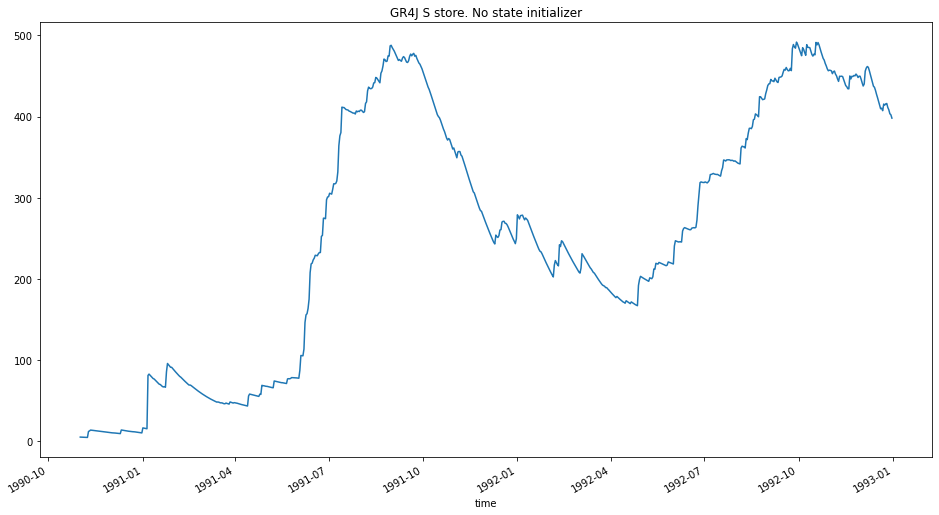

In [10]:
import matplotlib.pyplot as plt

ms.exec_simulation()
tts = ms.get_recorded(s_store_id)
tts = tts.squeeze(drop=True)
g = tts.plot.line(add_legend=True, figsize=(16,8))
plt.title('GR4J S store. No state initializer');

In [11]:
from swift2.utils import as_xarray_series

In [12]:
from swift2.vis import plot_two_series

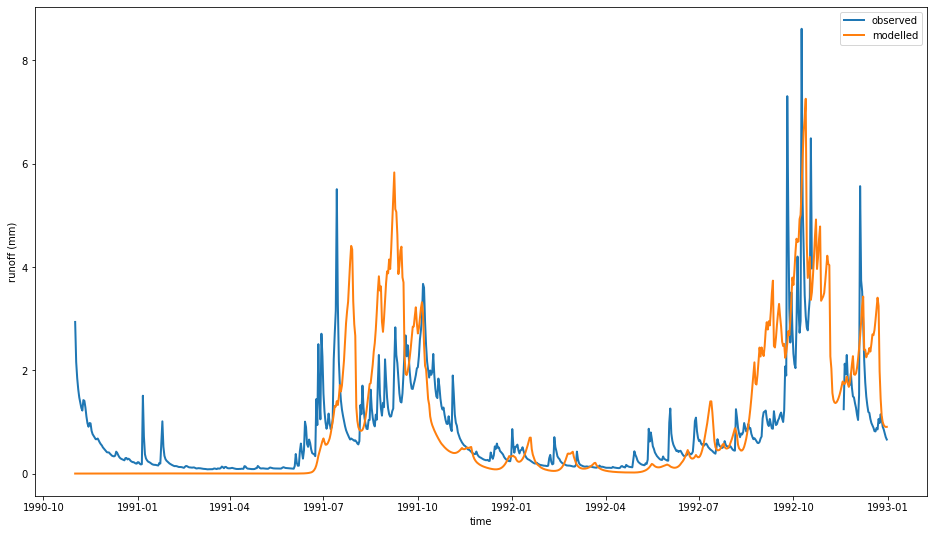

In [13]:
calc_runoff = ms.get_recorded(runoff_id).squeeze(drop=True)
plot_two_series(obs_runoff, calc_runoff, start_time = xr_ts_start(calc_runoff), end_time = xr_ts_end(calc_runoff), names=['observed','modelled'], xlab="time", ylab="runoff (mm)")

Let's define _S0_ and _R0_ parameters such that for each GR4J model instance, _S = S0 * x1_ and _R = R0 * x3_

In [14]:
from swift2.utils import c
p_states = sp.linear_parameteriser(
                      c("S0","R0"), 
                      c("S","R"), 
                      c("x1","x3"),
                      c(0.0,0.0), 
                      c(0.6,0.6), 
                      c(0.4,0.4), 
                      'each subarea')

If one applies this parameteriser _pState_ to the system, the the _S_ store is set to the expected value relative to _x1_.

In [15]:
p_states.apply_sys_config(ms)
ms.get_state_value(s_store_id)

{'subarea.Subarea.S': 260.19520000000006}

**However** this is not enough to define a parameteriser as an initial state. If executing the simulation, the time series of _S_ still starts at zero, because the resetting the model overrides the state _S_:

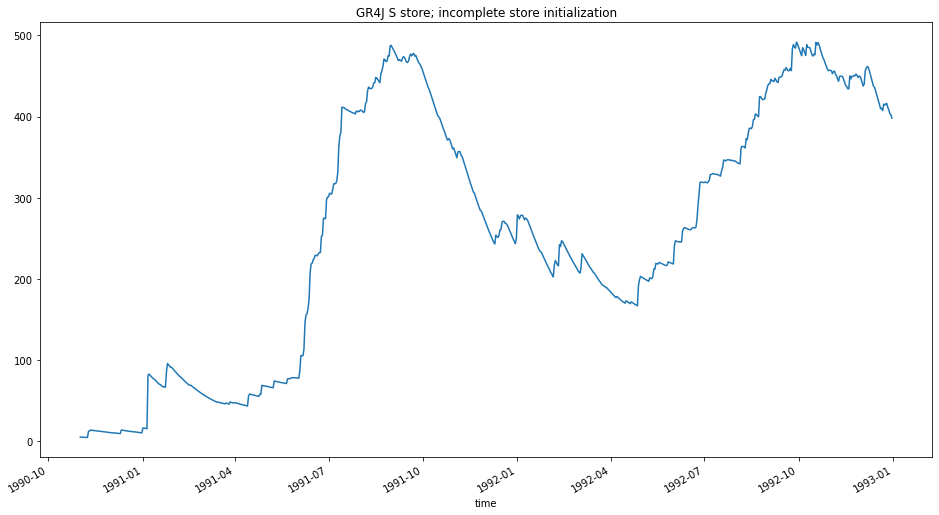

In [16]:
ms.exec_simulation()
tts = ms.get_recorded(s_store_id)
tts = tts.squeeze(drop=True)
g = tts.plot.line(add_legend=True, figsize=(16,8))
plt.title('GR4J S store; incomplete store initialization');

You need to define a new parameteriser, that makes sure that the model is reset to the expected initial value.

In [17]:
init_parameteriser = p_states.make_state_init_parameteriser()
init_parameteriser.apply_sys_config(ms)

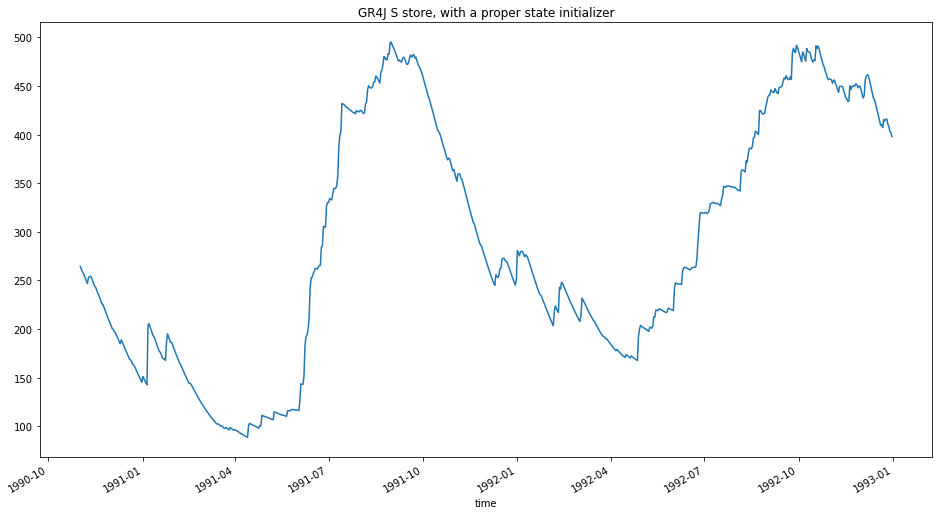

In [18]:
ms.exec_simulation()
tts = ms.get_recorded(s_store_id)
tts = tts.squeeze(drop=True)
g = tts.plot.line(add_legend=True, figsize=(16,8))
plt.title('GR4J S store, with a proper state initializer');

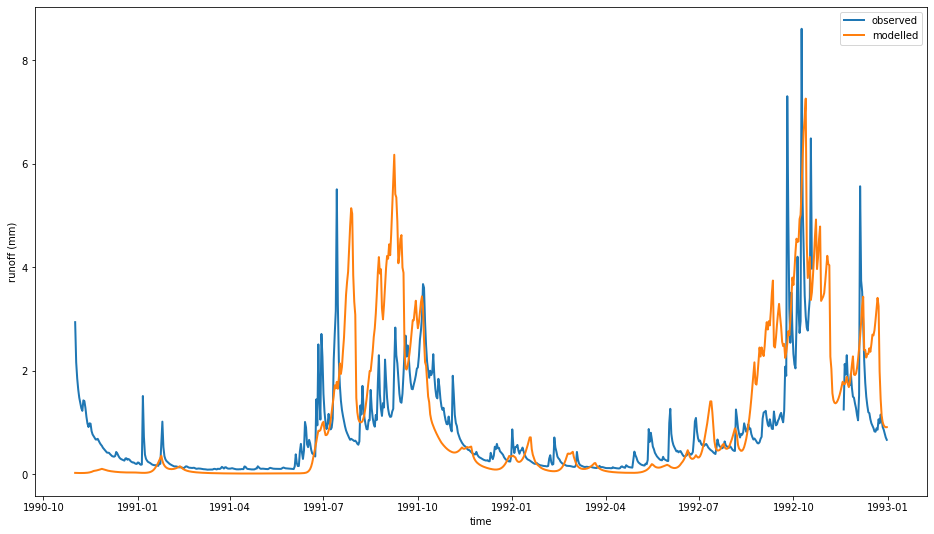

In [19]:
calc_runoff = ms.get_recorded(runoff_id).squeeze(drop=True)
plot_two_series(obs_runoff, calc_runoff, start_time = xr_ts_start(calc_runoff), end_time = xr_ts_end(calc_runoff), names=['observed','modelled'], xlab="time", ylab="runoff (mm)")

There is logic in keeping the two previous steps in defining a parameteriser as separate, hence this present vignette emphasizes the importance of these two steps.

## Calibration

Once you have defined this state initialisation parameteriser using `{r eval=FALSE} makeStateInitParameterizer`, you can define a calibration objective the usual way. This vignette does not include calibration steps; please refer to other vignettes.

In [20]:
p_composite = CompositeParameteriser.concatenate(p, init_parameteriser)
print(p_composite)

                 Name       Value   Min     Max
0  subarea.Subarea.x1  650.488000   1.0  3000.0
1  subarea.Subarea.x2   -0.280648 -27.0    27.0
2  subarea.Subarea.x3    7.891230   1.0   660.0
3  subarea.Subarea.x4   18.917200   1.0   240.0
4                  R0    0.400000   0.0     0.6
5                  S0    0.400000   0.0     0.6


In [21]:
objective = ms.create_objective(runoff_id, obs_runoff, 'NSE', w, e)
score = objective.get_score(p_composite)
print(score)

{'scores': {'NSE': -0.03575597073595449}, 'sysconfig':                  Name       Value   Min     Max
0  subarea.Subarea.x1  650.488000   1.0  3000.0
1  subarea.Subarea.x2   -0.280648 -27.0    27.0
2  subarea.Subarea.x3    7.891230   1.0   660.0
3  subarea.Subarea.x4   18.917200   1.0   240.0
4                  R0    0.400000   0.0     0.6
5                  S0    0.400000   0.0     0.6}


In [22]:
optim = objective.create_sce_optim_swift(population_initialiser=p)

In [23]:
%%time
results = optim.execute_optimisation()

CPU times: user 36.5 s, sys: 45.2 ms, total: 36.5 s
Wall time: 9.49 s


In [24]:
results.get_best_score('NSE', convert_to_py=True)

{'scores': {'NSE': 0.5625971076046495},
 'sysconfig':                  Name       Value   Min     Max
 0  subarea.Subarea.x1  580.276219   1.0  3000.0
 1  subarea.Subarea.x2  -13.355840 -27.0    27.0
 2  subarea.Subarea.x3  584.391889   1.0   660.0
 3  subarea.Subarea.x4    1.178550   1.0   240.0}

In [25]:
s = results.get_best_score('NSE')

In [26]:
s.apply_sys_config(ms)
ms.exec_simulation()

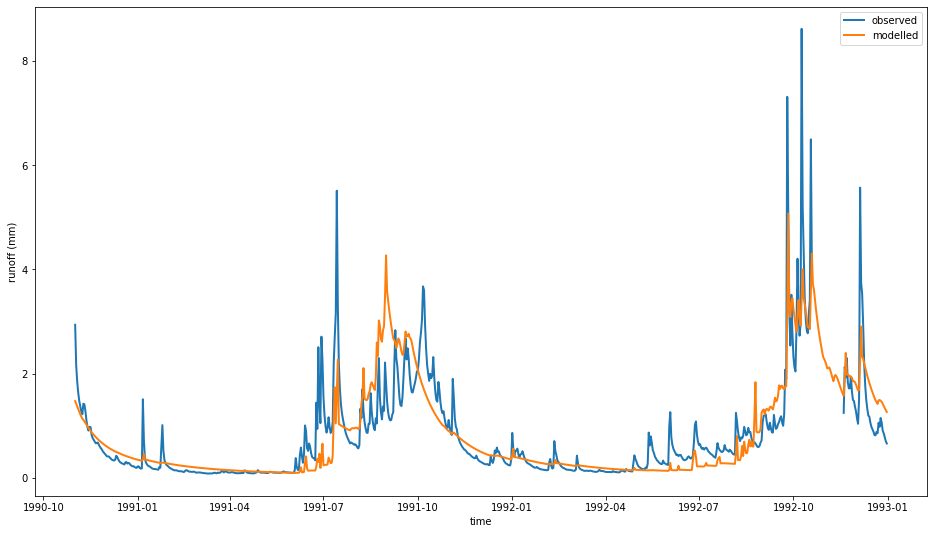

In [27]:
calc_runoff = ms.get_recorded(runoff_id).squeeze(drop=True)
plot_two_series(obs_runoff, calc_runoff, start_time = xr_ts_start(calc_runoff), end_time = xr_ts_end(calc_runoff), names=['observed','modelled'], xlab="time", ylab="runoff (mm)")

In [28]:
optim = objective.create_sce_optim_swift(population_initialiser=p_composite)

In [29]:
%%time
results = optim.execute_optimisation()

CPU times: user 35.7 s, sys: 108 ms, total: 35.8 s
Wall time: 9.89 s


In [30]:
results.get_best_score('NSE', convert_to_py=True)

{'scores': {'NSE': 0.526419566545028},
 'sysconfig':                  Name       Value   Min     Max
 0  subarea.Subarea.x1  354.567580   1.0  3000.0
 1  subarea.Subarea.x2  -18.721008 -27.0    27.0
 2  subarea.Subarea.x3  646.923623   1.0   660.0
 3  subarea.Subarea.x4    1.709377   1.0   240.0
 4                  R0    0.251199   0.0     0.6
 5                  S0    0.454895   0.0     0.6}

In [31]:
s = results.get_best_score('NSE')

In [32]:
s.apply_sys_config(ms)
ms.exec_simulation()

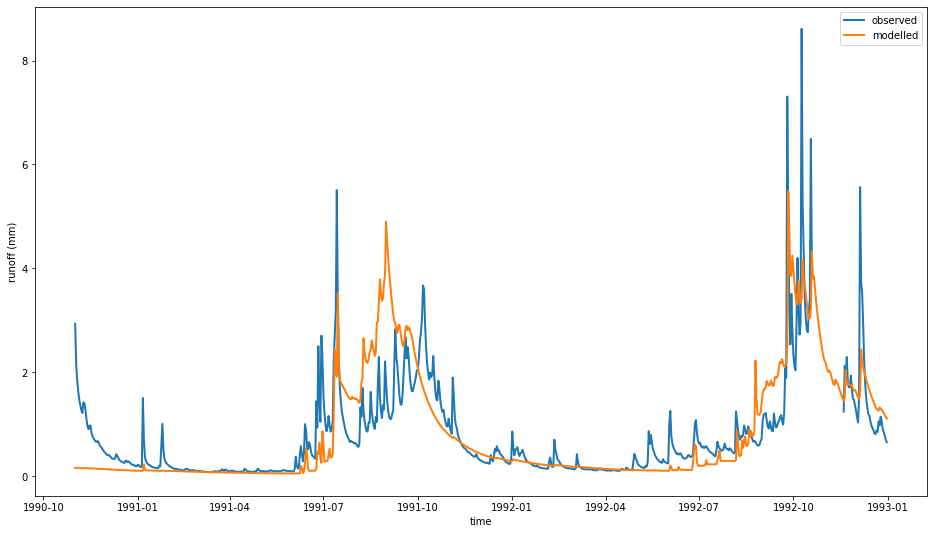

In [33]:
calc_runoff = ms.get_recorded(runoff_id).squeeze(drop=True)
plot_two_series(obs_runoff, calc_runoff, start_time = xr_ts_start(calc_runoff), end_time = xr_ts_end(calc_runoff), names=['observed','modelled'], xlab="time", ylab="runoff (mm)")

<AxesSubplot:>

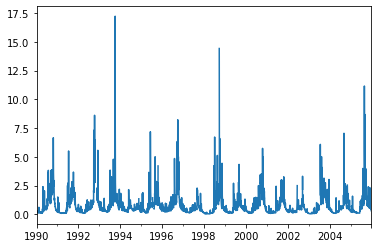

In [34]:
obs_runoff.plot()

In [35]:
x = ms.get_played('subcatchment.Subarea.P').squeeze(drop=True).to_series()

In [36]:
rainfall_mth = x.resample("M").sum()
runoff_mth = obs_runoff[slice(x.index[0], x.index[-1])].resample("M").sum()

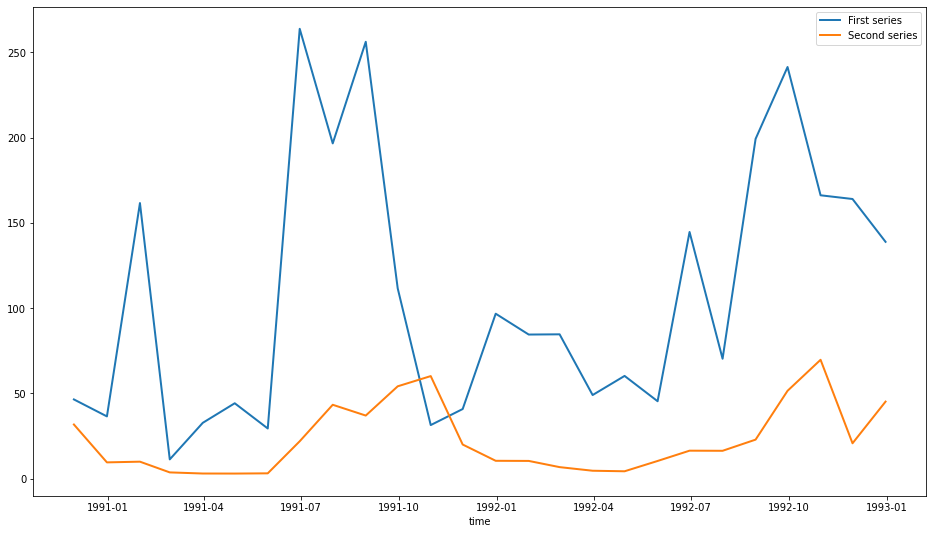

In [37]:
plot_two_series(rainfall_mth, runoff_mth)